In [1]:
%load_ext autoreload  
%autoreload 2 
%matplotlib inline

In [2]:
import octopus
from src import *

import numpy as np
import pandas as pd
import timm
from sklearn import metrics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations
from transformers import AdamW

In [6]:
class Config: 
    debug = True
    epochs = 5
    batch_size = 4
    image_size = 256

In [7]:
data_path = "./data"
df_train = pd.read_csv(f'{data_path}/train.csv')
if Config.debug: 
    df_train = df_train[:8]
train_img_paths = [f"{data_path}/train/{id}.jpg" for id in df_train["Id"].values]

In [14]:
train_aug = train_aug = albumentations.Compose(
    [
        albumentations.Resize(Config.image_size, Config.image_size, p=1),
        albumentations.HueSaturationValue(
            hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
        ),
        albumentations.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
        ),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)

dense_features = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]

train_ds = PawpularDataset(
    image_paths=train_img_paths,
    dense_features=df_train[dense_features].values,
    targets=df_train.Pawpularity.values,
    augmentation=train_aug
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


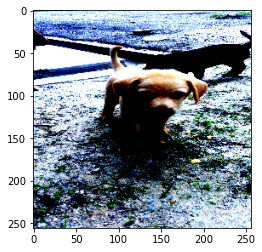

In [15]:
import matplotlib.pyplot as plt
plt.imshow(train_ds[0][0]['image'])

In [16]:
train_dl = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=False)

In [33]:
len(train_dl)

2

In [36]:
for batch_x, batch_y in train_dl:
    print(f"batch_x: {type(batch_x['image'])}, {batch_x['image'].shape} | batch_y: {batch_y}")

batch_x: torch.Size([4, 256, 256, 3]) | batch_y: tensor([63, 42, 28, 15])
batch_x: torch.Size([4, 256, 256, 3]) | batch_y: tensor([72, 74, 22, 35])


In [20]:
# classifier = timm.create_model("tf_efficientnet_b0_ns", pretrained=True, in_chans=3).classifier; print(classifier)

In [ ]:
# self.conv_stem = create_conv2d(in_chans, stem_size, 3, stride=2, padding=pad_type)

# def create_conv2d(in_channels, out_channels, kernel_size, **kwargs):
#     """ Select a 2d convolution implementation based on arguments
#     Creates and returns one of torch.nn.Conv2d, Conv2dSame, MixedConv2d, or CondConv2d.
#     Used extensively by EfficientNet, MobileNetv3 and related networks.
#     """
#     if isinstance(kernel_size, list):
#         assert 'num_experts' not in kwargs  # MixNet + CondConv combo not supported currently
#         assert 'groups' not in kwargs  # MixedConv groups are defined by kernel list
#         # We're going to use only lists for defining the MixedConv2d kernel groups,
#         # ints, tuples, other iterables will continue to pass to normal conv and specify h, w.
#         m = MixedConv2d(in_channels, out_channels, kernel_size, **kwargs)
#     else:
#         depthwise = kwargs.pop('depthwise', False)
#         # for DW out_channels must be multiple of in_channels as must have out_channels % groups == 0
#         groups = in_channels if depthwise else kwargs.pop('groups', 1)
#         if 'num_experts' in kwargs and kwargs['num_experts'] > 0:
#             m = CondConv2d(in_channels, out_channels, kernel_size, groups=groups, **kwargs)
#         else:
#             m = create_conv2d_pad(in_channels, out_channels, kernel_size, groups=groups, **kwargs)
#     return m

In [21]:
model = PawpularModel()

In [22]:
cbs = [octopus.ProgressBar(), octopus.TrackLoss(save_model=False, path="./", model_name=f"pawpular")]

In [23]:
epochs = 4
training_steps = len(train_dl) * epochs; print("training steps: ", training_steps)
dls = octopus.DataLoaderGroup(train_dl, train_dl)
loss_func = nn.MSELoss()
lr = 2e-5
optimizer = AdamW(model.parameters(), lr = lr)

training steps:  8


In [24]:
learner = octopus.Learner(model, 
                  dls, 
                  loss_func, 
                  optimizer, 
                  lr,  
                  valid_interval=len(train_dl),
                  cbs=cbs)

In [25]:
learner.fit(3)

epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[4, 256, 257, 5] to have 3 channels, but got 256 channels instead